In [1]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt

/Users/waficel-assi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
cd "/Users/waficel-assi/Desktop/StatsMSc/instacart-kaggle"

/Users/waficel-assi/Desktop/StatsMSc/instacart-kaggle


In [21]:
def user_embedding(inputs, n_users, embedding_dim):
    with tf.variable_scope('user_embedding', reuse=tf.AUTO_REUSE):
        
        #TODO: create embedding matrix for user and query embedding vector
        user_embeddings = tf.get_variable('embeddings_users', [n_users, embedding_dim])
        embed_user_ids = tf.nn.embedding_lookup(user_embeddings, inputs, name='user_vector')

        #TODO: return user embedding vector
        return embed_user_ids


In [20]:
def product_embedding(inputs, n_prods, embedding_dim):
    with tf.variable_scope('product_embedding', reuse=tf.AUTO_REUSE):
        #TODO: create embedding matrix for product and query embedding vector
        product_embeddings = tf.get_variable('embeddings_prods', [n_prods, embedding_dim])
        embed_product_ids = tf.nn.embedding_lookup(product_embeddings, inputs)

        #TODO: return user embedding vector
        return embed_product_ids


In [33]:
def output_layer(user, product):
    # TODO: given user vector and product vector, implementate prediction function
    input_1 = tf.concat([user, product], 1)
    ouputNET_hidden = slim.fully_connected(input_1, num_outputs=50, activation_fn=tf.nn.tanh, scope='output_1', reuse=tf.AUTO_REUSE)
    
    ouputNET = slim.fully_connected(ouputNET_hidden, num_outputs=1, activation_fn=None, scope='output_2', reuse=tf.AUTO_REUSE)

    return ouputNET

In [90]:
def data():
    """
    Data preprocesing function
    """
    order_products_prior_df = pd.read_csv('data/order_products__prior.csv', engine='c',
                                          dtype={'order_id': np.int32, 'product_id': np.int32,
                                                 'add_to_cart_order': np.int16, 'reordered': np.int8})


    order_products_train_df = pd.read_csv('data/order_products__train.csv', engine='c',
                                          dtype={'order_id': np.int32, 'product_id': np.int32,
                                                 'add_to_cart_order': np.int16, 'reordered': np.int8})

    orders_df = pd.read_csv('data/orders.csv', engine='c',
                            dtype={'order_id': np.int32, 'user_id': np.int32, 'order_number': np.int32,
                                   'order_dow': np.int8, 'order_hour_of_day': np.int8,
                                   'days_since_prior_order': np.float16})

    products_df = pd.read_csv("data/products.csv", engine='c')

    df_train = orders_df.merge(order_products_train_df, how='inner', on='order_id')
    df_train = df_train.merge(products_df, how='inner', on='product_id')
    df_train.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

    df_prior = orders_df.merge(order_products_prior_df, how='inner', on='order_id')
    df_prior = df_prior.merge(products_df, how='inner', on='product_id')
    df_prior.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

    df = pd.concat([df_prior, df_train])

    # fillna
    df.fillna(0, axis=0, inplace=True)
    df.drop('eval_set', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    del df_train, df_prior

    sample = int(1e5)
    df = df.iloc[:sample]
    df.head(3)

    # Update product and user ids so that they are contiguous integers, which we want when using embeddings.
    g = df.groupby(['user_id', 'product_name', 'product_id'])

    # create prod_rating df and add a product_count feature (i.e. how many times has the user reordered the product)
    prod_ratings = g['reordered'].count().reset_index()
    prod_ratings.columns = ['user_id', 'product_name', 'product_id', 'product_count']

    users = prod_ratings.user_id.unique()
    prods = prod_ratings.product_id.unique()

    userid2idx = {o: i for i, o in enumerate(users)}
    prodid2idx = {o: i for i, o in enumerate(prods)}

    prod_ratings.product_id = prod_ratings.product_id.apply(lambda x: prodid2idx[x])
    prod_ratings.user_id = prod_ratings.user_id.apply(lambda x: userid2idx[x])

    n_users = prod_ratings.user_id.nunique()
    n_prods = prod_ratings.product_id.nunique()
    print("num of users: ", n_users)
    print("num of prods: ",  n_prods)

    def round_rating(number):
        """Round a number to the closest half integer"""
        return np.round(number * 2) / 2

    mapper = DataFrameMapper([(['product_count'], MinMaxScaler())], df_out=True)

    # apply the mapper to each user and concatenate results
    dfs = [np.round(mapper.fit_transform(prod_ratings[prod_ratings.user_id == u].copy()), 1) for u in range(n_users)]

    prod_ratings['product_score'] = pd.concat(dfs).reset_index(drop=True) * 4 + 1
    prod_ratings['product_score'] = round_rating(prod_ratings['product_score'])  # .astype(int)
    # print(prod_ratings.shape)
    prod_ratings.head(20)
    np.random.seed(1001)
    msk = np.random.rand(len(prod_ratings)) < 0.8
    trn = prod_ratings[msk]
    val = prod_ratings[~msk]

    return trn, val, n_users, n_prods

In [91]:
def main():
    """
    DATA useage
    user_id : train.user_id
    product_id : train.product_id
    product_score: train.product_score
    """
    embedding_dim = 50
    batch_size = 1024

    train, val, n_users, n_prods = data()
    num_training_data = len(train.user_id)
    num_val_data = len(val.user_id)

    print("num of training data: ", num_training_data)
    print("num of val data: ", num_val_data)

    user = tf.placeholder(tf.int32, [None])
    product = tf.placeholder(tf.int32, [None])
    score = tf.placeholder(tf.float32, shape=[None])

    # TODO: use user_embedding and product_embedding function to find embedding vector
    user_vector = user_embedding(user, n_users, embedding_dim)
    prod_vector = product_embedding(product, n_prods, embedding_dim)

    output = output_layer(user_vector, prod_vector)

    # TODO: implementate loss function
    loss = tf.losses.mean_squared_error(output[:,0], score)
    train_op = tf.train.AdamOptimizer(0.001, name="Adam_5").minimize(loss)

    val_loss = []
    with tf.Session() as sess:
        # you need to initialize all variables
        tf.global_variables_initializer().run()

        for epoch in range(10):
            for iter in range(int(num_training_data / batch_size)):
                curr_user_id = train.user_id[iter * batch_size : iter* batch_size + batch_size ].values
                curr_product_id = train.product_id[iter * batch_size : iter* batch_size + batch_size ].values
                curr_product_score = train.product_score[iter * batch_size : iter* batch_size + batch_size ].values

                L , _ = sess.run([loss, train_op], feed_dict={user: curr_user_id,
                                                          product: curr_product_id,
                                                          score: curr_product_score})

                if iter % 100 == 0:
                    print('Train Loss at epoch {} : {} '.format(str(epoch),str(L)))

                if iter % 300 == 0:
                    curr_user_id = val.user_id.values
                    curr_product_id = val.product_id.values
                    curr_product_score = val.product_score.values

                    L = sess.run(loss, feed_dict={user: curr_user_id,
                                                              product: curr_product_id,
                                                              score: curr_product_score})

                    print('Validataion Loss at epoch {} : {} '.format(str(epoch), str(L)))

                    val_loss.append(L)
    plt.plot(val_loss, '--', color="#111111", label="score")
    plt.show()

num of users:  667
num of prods:  12469


/Users/waficel-assi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


num of training data:  33360
num of val data:  8330
Train Loss at epoch 0 : 3.039542 
Validataion Loss at epoch 0 : 3.036833 
Train Loss at epoch 1 : 1.598002 
Validataion Loss at epoch 1 : 1.6370692 
Train Loss at epoch 2 : 0.89687854 
Validataion Loss at epoch 2 : 0.93542844 
Train Loss at epoch 3 : 0.75159454 
Validataion Loss at epoch 3 : 0.88704365 
Train Loss at epoch 4 : 0.68840057 
Validataion Loss at epoch 4 : 0.8790905 
Train Loss at epoch 5 : 0.6472899 
Validataion Loss at epoch 5 : 0.8828277 
Train Loss at epoch 6 : 0.6197268 
Validataion Loss at epoch 6 : 0.8897178 
Train Loss at epoch 7 : 0.6014187 
Validataion Loss at epoch 7 : 0.8982248 
Train Loss at epoch 8 : 0.5890427 
Validataion Loss at epoch 8 : 0.91004765 
Train Loss at epoch 9 : 0.5808765 
Validataion Loss at epoch 9 : 0.9171536 


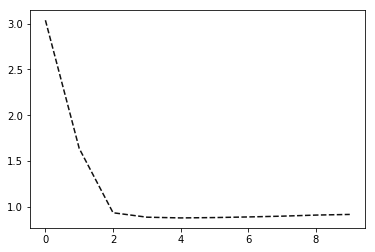

In [92]:
if __name__ == '__main__':
    main()